In [2]:
%pylab notebook

from scipy.optimize import curve_fit

import sys, os, importlib, warnings, pandas as pd, seaborn as sns
warnings.filterwarnings("ignore")

sys.path.append('/Users/alexisdevitre/Documents/code/hts-irradiation')
import hts_fitting as hts, hts_fitfunctions as ff, hts_misc as misc, default_figure_style as dfs
for lib in [hts, dfs, ff, misc]:
    importlib.reload(lib)


label_suppression = 'Suppression $\mathrm{1 - I_c^{ON} / I_c^{OFF}}$'
label_degradation = 'Degradation $I_c^{OFF} / I_c^{0}$'

#################################
########## Correction ###########
#################################

def sqrt4(x, a, b, c, d):
    return a*np.sqrt(c*x+d)+b

#################################
########## Load data ############
#################################

masterfile = '../data/data-master-linear.xlsx'
cols = [0, 1, 12, 13, 14, 19, 23, 25, 27, 29, 39, 41, 43, 45, 52, 53, 54, 55, 56, 57, 58, 59]
names = [
    'tapeid', 
    'anneal',
    'energy', 
    'power', 
    'powerError',
    'ic0',
    'icoff',
    'noff',
    'icon',
    'non',
    
    'tHTS_OFF',
    'tTAR_OFF',
    'tHTS_ON',
    'tTAR_ON',
    
    'tREBCO',
    'degradation',
    'degradationError',
    'suppression', 
    'suppressionError',
    'suppression_corrected',
    'suppressionError_corrected',
    'outlier' 
]
df = pd.read_excel(masterfile, sheet_name='data', usecols=cols, names=names, skiprows=1)

#################################
########## Filter data ##########
#################################
cut = df.tTAR_OFF <= 20
cut &= (df.suppression != np.nan) & (df.suppression > 0) & (df.suppressionError > 0)
cut &= df.outlier != 1
data = df[cut]

print('\n\nTotal datapoints', data.energy.count())
for tapeid in data.tapeid.unique():
    print('\nDatapoints for', tapeid, data[data.tapeid==tapeid].energy.count())

df.columns
outputDirectory = '../figures/raw/'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Total datapoints 689

Datapoints for f33 68

Datapoints for f20 14

Datapoints for f34 9

Datapoints for f29 304

Datapoints for f23 2

Datapoints for f28 69

Datapoints for f37 223


<IPython.core.display.Javascript object>


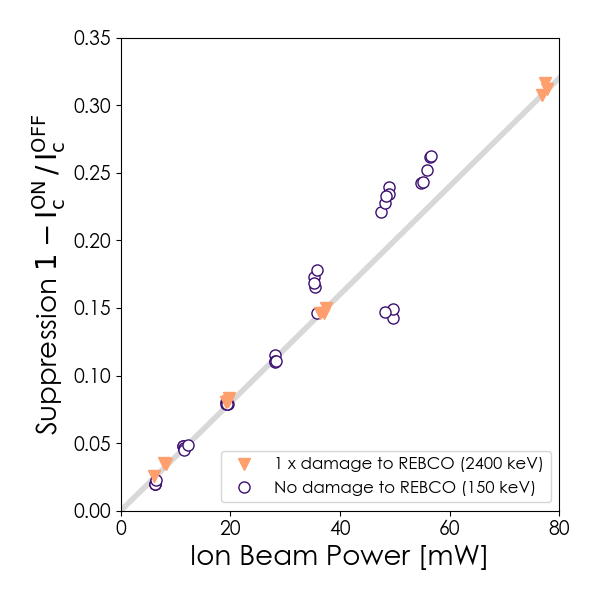

In [211]:
fig, ax = plt.subplots()
x, ex = data.power, data.powerError
y, ey = data.suppression, data.suppressionError


cut = (data.tapeid == 'f37') & ((data.energy == 150) | (data.energy == 2400)) & (data.power < 100)
popt, pcov = curve_fit(ff.affine, x[cut], y[cut]) 

ax.plot(np.linspace(0, 100, 10000), ff.affine(np.linspace(0, 100, 10000), *popt), linewidth=4, linestyle='-', alpha=.3, color='gray')
ax.plot(np.linspace(102, 250, 10000),  ff.affine(np.linspace(102, 250, 10000), *popt), linewidth=4, linestyle=':', alpha=.3, color='gray')

energy = 150
cut = (data.tapeid == 'f37') & (data.energy == energy)
ax.plot(x[cut], y[cut], marker='o', markersize=8, linestyle='None', mfc='white', color=dfs.colors_energies[str(energy)], alpha=1, label='No damage to REBCO ({:3.0f} keV)'.format(energy))

energy = 2400
cut = (data.tapeid == 'f37') & (data.energy == energy)
ax.plot(x[cut], y[cut], marker='v', markersize=8, linestyle='None', color=dfs.colors_energies[str(energy)], alpha=1, label='1 x damage to REBCO ({:3.0f} keV)'.format(energy))

    
#ax.errorbar(x[cut], y[cut], xerr=ex[cut], yerr=ey[cut], marker='None', linestyle='None', color=c, alpha=.5)
ax.set_ylim(0, 0.35)
ax.set_xlim(0, 80)
    
    
#for axis in axes:
#    for ax in axis:
#        ax.set_rasterized(True)

ax.set_xlabel('Ion Beam Power [mW]')
ax.set_ylabel('Suppression $\mathrm{1 - I_c^{ON}\, /\, I_c^{OFF}}$')
fig.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='lower right')

plt.savefig(dfs.outputDirectory+'150v2400keV.svg')

<IPython.core.display.Javascript object>


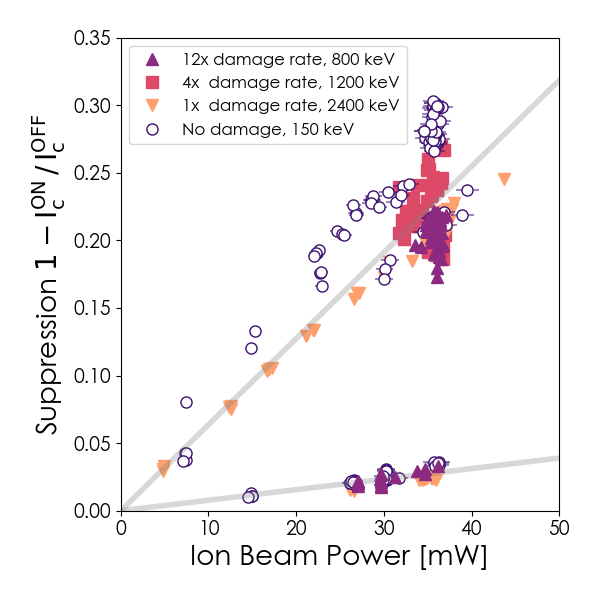

In [209]:
fitfunction = ff.affine
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
labels = {
    '800': '12x damage rate, 800 keV',
    '1200': '4x  damage rate, 1200 keV',
    '2400': '1x  damage rate, 2400 keV',
    '150': 'No damage, 150 keV'
}


for tape in ['f29', 'f33']:
    d = data[(data.tapeid == tape)]# & (data.anneal == 1)]
    x, ex = d.power, d.powerError
    y, ey = d.suppression_corrected, d.suppressionError
    #z, ey = d.suppression, d.suppressionError

    popt, pcov = curve_fit(fitfunction, x, y)
    xsmooth = np.linspace(0, 150, 10000)
    ysmooth = fitfunction(xsmooth, *popt)

    ax.plot(xsmooth, ysmooth, linewidth=4, alpha=.3, color='gray')

    for e, m in zip([800, 1200, 2400, 150], ['^', 's', 'v', 'o']):
        cut = (d.energy == e)
        c = mec = mfc = dfs.colors_energies[str(e)]
        if tape == 'f29':
            l = labels[str(e)]
        else:
            l = ''
        if e == 150:
            mfc = 'white'
        elif e == 800:
            zorder = 20
        else:
            zorder = 1

        ax.errorbar(x[cut], y[cut], xerr=ex[cut], yerr=ey[cut], linestyle='None', marker='None', color=c, alpha=.5, zorder=1)
        ax.plot(x[cut], y[cut], marker=m, linestyle='None', mec=mec, mfc=mfc, markersize=8, label='{:>}'.format(l), zorder=zorder)




#ss, ee = [], []
#s36mW = ff.affine(36, *popt)
#for s, e in zip((s36mW*y/(popt[0]*x)).values, dataf29.energy):
#    ss.append(s)
#    ee.append(e)  
    
    
    
    
    
ax.set_ylabel('Suppression $\mathrm{1 - I_c^{ON}\, /\, I_c^{OFF}}$')
ax.set_xlabel('Ion Beam Power [mW]')
ax.legend(loc='upper left')
ax.set_ylim(0, .35)
ax.set_xlim(0, 50)
fig.tight_layout()
ax.set_rasterized(True)
plt.savefig(outputDirectory+'150v2400v1200v800keV.svg', facecolor='white')

<IPython.core.display.Javascript object>


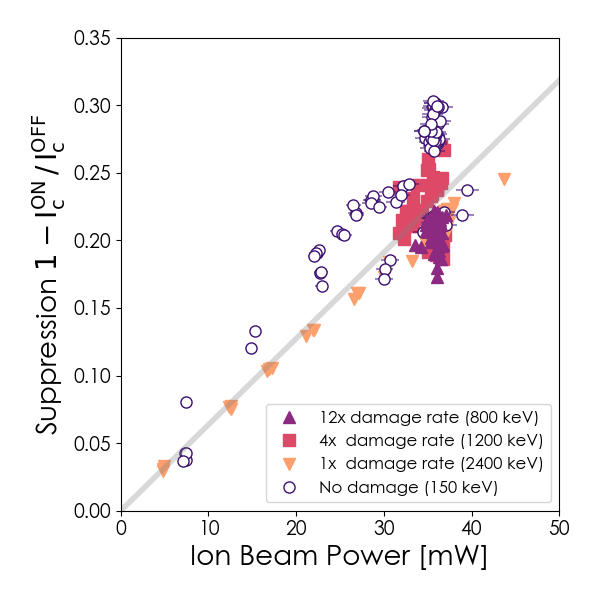

In [189]:
fitfunction = ff.affine

labels = [
    '12x damage rate (800 keV)',
    '4x  damage rate (1200 keV)',
    '1x  damage rate (2400 keV)',
    'No damage (150 keV)',
]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

dataf29 = data[df.tapeid == 'f29']
x, ex = dataf29.power, dataf29.powerError
y, ey = dataf29.suppression_corrected, dataf29.suppressionError
z, ey = dataf29.suppression, dataf29.suppressionError

popt, pcov = curve_fit(fitfunction, x, y)
xsmooth = np.linspace(0, 150, 10000)
ysmooth = fitfunction(xsmooth, *popt)






#ss, ee = [], []
#s36mW = ff.affine(36, *popt)
#for s, e in zip((s36mW*y/(popt[0]*x)).values, dataf29.energy):
#    ss.append(s)
#    ee.append(e)

ax.plot(xsmooth, ysmooth, linewidth=4, alpha=.3, color='gray')

for e, m, l in zip([800, 1200, 2400, 150], ['^', 's', 'v', 'o'], labels):
    cut = (dataf29.energy == e)
    c = mec = mfc = dfs.colors_energies[str(e)]
    if e == 150:
        mfc = 'white'
    elif e == 800:
        zorder = 20
    else:
        zorder = 1
    
    ax.errorbar(x[cut], y[cut], xerr=ex[cut], yerr=ey[cut], linestyle='None', marker='None', color=c, alpha=.5, zorder=1)
    ax.plot(x[cut], y[cut], marker=m, linestyle='None', mec=mec, mfc=mfc, markersize=8, label='{:>}'.format(l), zorder=zorder)
    #ax.plot(x[cut], z[cut], color='lightgray', linestyle='None', marker=m, alpha=.3, zorder=30)
    
    
    
    
    
    
ax.set_ylabel('Suppression $\mathrm{1 - I_c^{ON}\, /\, I_c^{OFF}}$')
ax.set_xlabel('Ion Beam Power [mW]')
ax.legend(loc='lower right')
ax.set_ylim(0, .35)
ax.set_xlim(0, 50)
fig.tight_layout()
ax.set_rasterized(True)
plt.savefig(outputDirectory+'150v2400v1200v800keV.svg', facecolor='white')

<IPython.core.display.Javascript object>


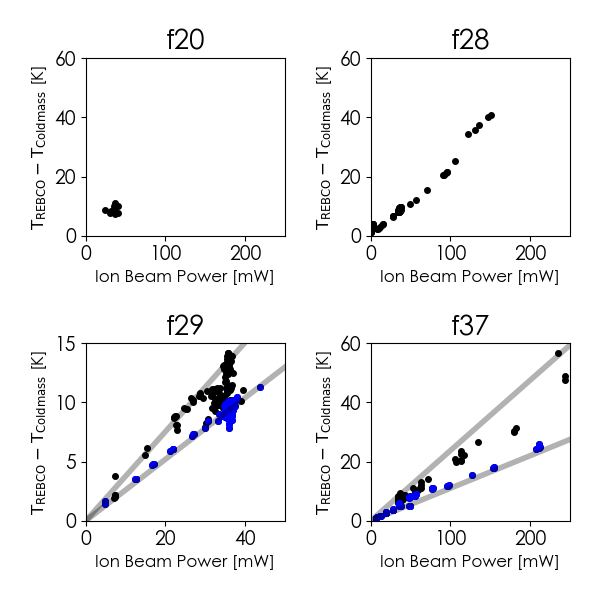

In [173]:
fig, axes = plt.subplots(2, 2)

degradation_slopes = [-0.06101488015796797, -0.14941426868018123, -0.061583263968482065, -0.17167675864773338]


labels = {
    '150': '150 keV',
    '800': '800 keV',
    '1200': '1200 keV',
    '2400': '2400 keV' 
}
markers = {
    '150': 'o', 
    '800': '^', 
    '1200':'s', 
    '2400': 'v'
}
ecolors = {
    '150': '#e88972',
    '800': '#d65161',
    '1200': '#b04a7a',
    '2400': '#7e3574'
}


for tapeid, ds, ax in zip(['f20', 'f28', 'f29', 'f37'], degradation_slopes, axes.flatten()):
    cut = (data.tapeid == tapeid)
    
    x, ex = data.power, data.powerError
    y, ey = data.tREBCO-data.tTAR_ON, data.suppressionError
    #z, ez = data.suppression, data.suppressionError
    
    #ax.plot(x[cut], z[cut], marker='o', linestyle='None', color='gray', markersize=4, alpha=.5)
    ax.plot(x[cut], y[cut], marker='o', linestyle='None', color='k', markersize=4, alpha=1)
    
    cut = (data.tapeid == tapeid) & (data.anneal > 1)
    #ax.plot(x[cut], z[cut], marker='o', linestyle='None', color='lightblue', markersize=4, alpha=1)
    ax.plot(x[cut], y[cut], marker='o', linestyle='None', color='b', markersize=4, alpha=1)
    
    ax.set_ylim(0, 60)
    #ax.set_ylim(0, 1)
    
    #ax.set_xlim(0, 7)
    ax.set_xlim(0, 250)
    ax.set_title(tapeid)
    
    xs = np.linspace(0, 300, 10000) 
    if tapeid == 'f37':
        alpha = 0.11
        ax.plot(xs, alpha*xs, color='k', linewidth=4, alpha=.3)
        ax.plot(xs, 2.16*alpha*xs, color='k', linewidth=4, alpha=.3)
    if tapeid == 'f29':
        alpha = 0.26
        ax.plot(xs, alpha*xs, color='k', linewidth=4, alpha=.3)
        ax.plot(xs, 1.45*alpha*xs, color='k', linewidth=4, alpha=.3)
        ax.set_xlim(0, 50)
        ax.set_ylim(0, 15)
    ax.set_xlabel('Ion Beam Power [mW]', fontsize=12)
    ax.set_ylabel('$\mathrm{T_{REBCO}-T_{Cold mass}}$ [K]', fontsize=12)
    
#fig.text(0.5, 0.02, 'Ion Beam Power [mW]', ha='center', va='center', fontweight='bold')
#fig.text(0.04, 0.5, 'Suppression $\mathrm{1 - I_c^{ON}\, /\, I_c^{OFF}}$', ha='center', va='center', fontweight='bold', rotation=90)
#fig.text(0.02, 0.5, '$\mathrm{T_{REBCO}-T_{Cold mass}}$', ha='center', va='center', fontweight='bold', rotation=90)

fig.tight_layout()

#plt.savefig(outputDirectory+'figure10-powerscaling.svg')    

<IPython.core.display.Javascript object>


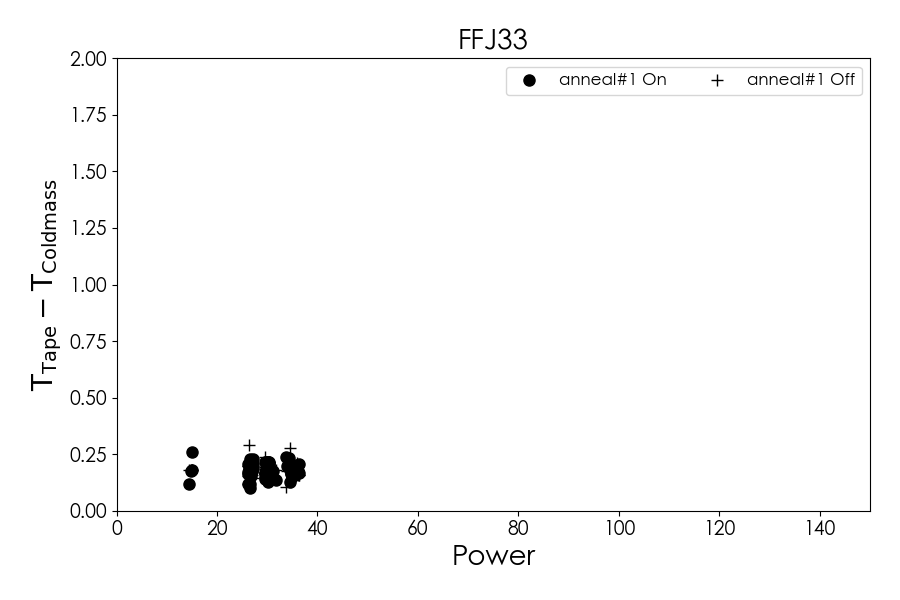

<IPython.core.display.Javascript object>


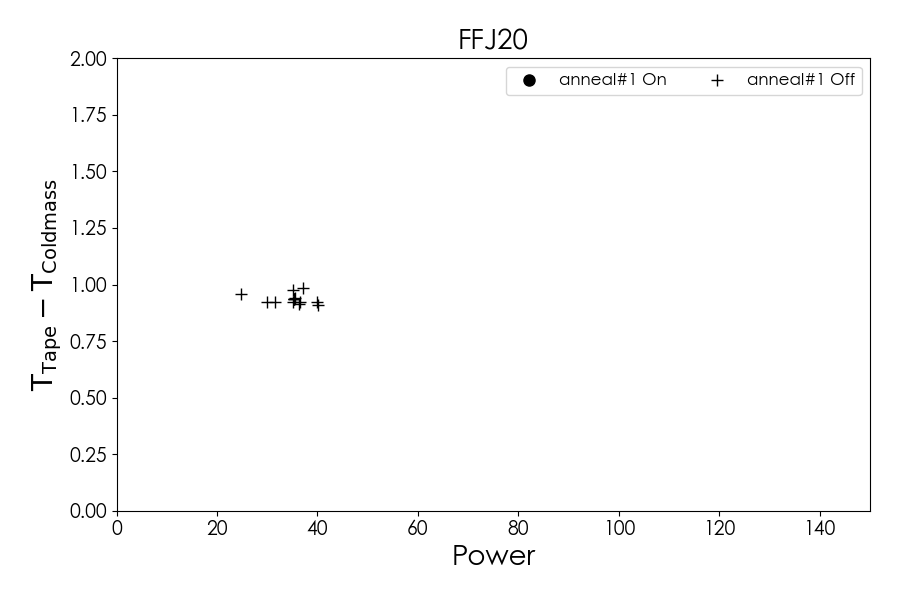

<IPython.core.display.Javascript object>


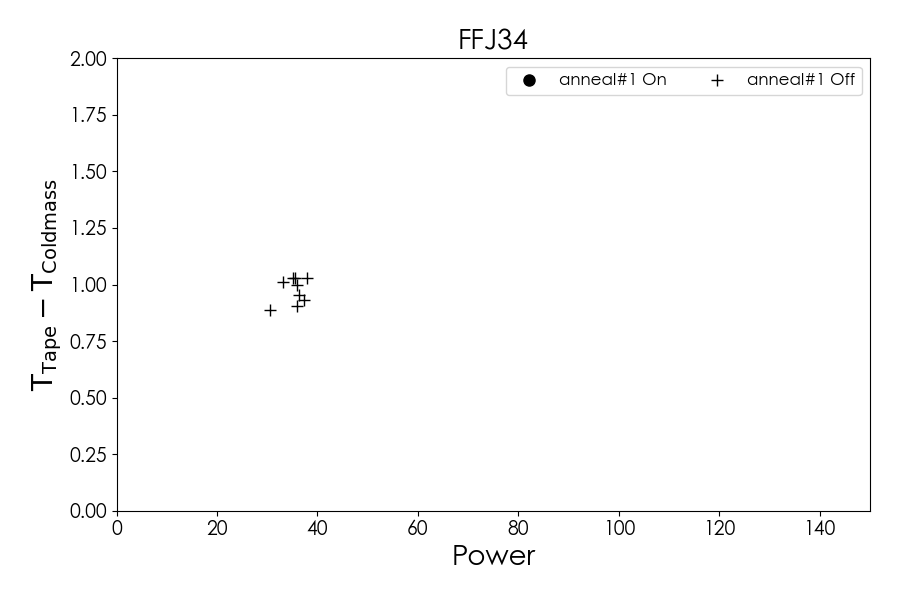

<IPython.core.display.Javascript object>


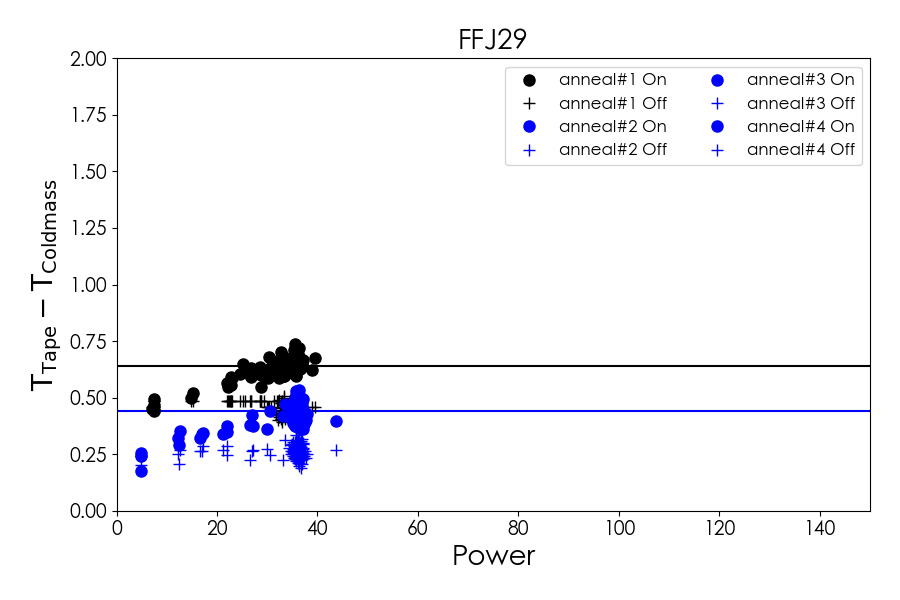

<IPython.core.display.Javascript object>


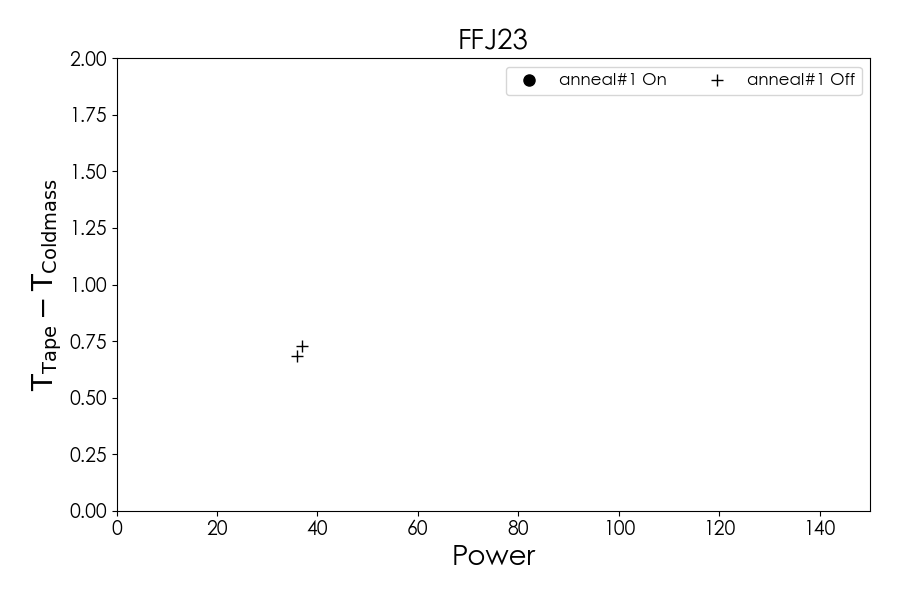

<IPython.core.display.Javascript object>


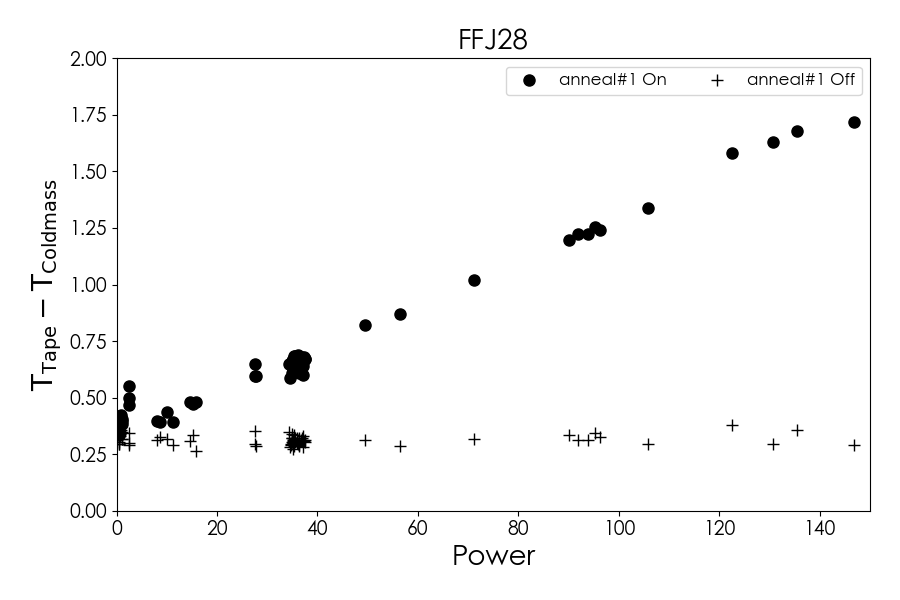

<IPython.core.display.Javascript object>


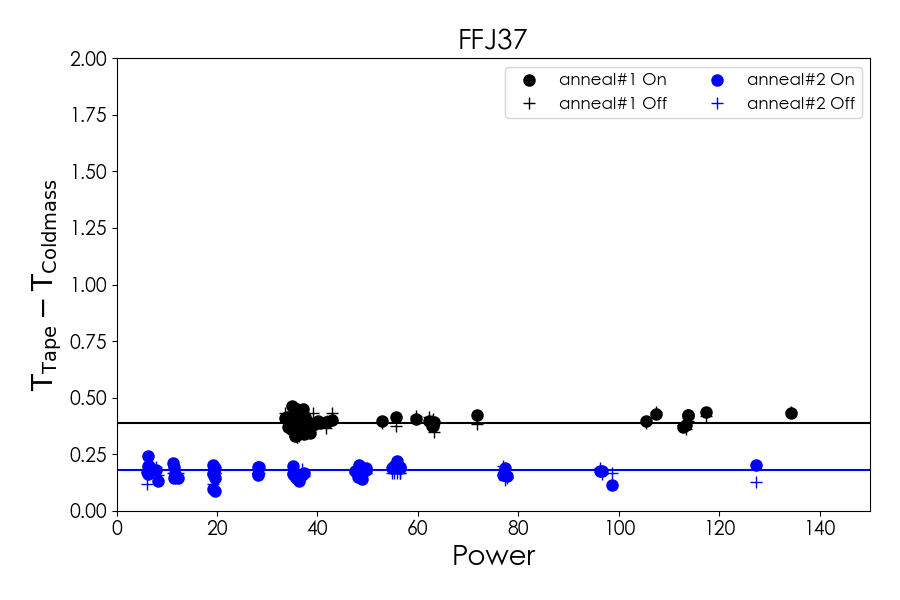

In [4]:


for tape in data.tapeid.unique():
    fig, ax = plt.subplots(figsize=(9, 6))
    anneals = data[(data.tapeid == tape)].anneal.unique()
    
    for a, c in zip(anneals, sns.color_palette('viridis', len(anneals))):
        if a == 1:
            c = 'k'
            if tape == 'f29':
                ax.axhline(0.64, color='k')
                ax.axhline(0.44, color='b')
            elif tape == 'f37':
                ax.axhline(0.18, color='b')
                ax.axhline(0.39, color='k')
        else:
            c = 'b'
        dfi = data[(data.tapeid == tape) & (data.anneal == a)]
        cut = (dfi.power <= 300)
        ax.plot(dfi.power[cut], dfi.tHTS_ON[cut]-dfi.tTAR_ON[cut], marker='o', color=c, label='anneal#'+str(a)+' On', linestyle='None')
        ax.plot(dfi.power[cut], dfi.tHTS_OFF[cut]-dfi.tTAR_OFF[cut], marker='+', color=c, label='anneal#'+str(a)+' Off', linestyle='None')
        
    ax.legend(ncols=2)
    ax.set_ylim(0, 2)
    ax.set_xlim(0, 150)
    
    ax.set_title(tape.replace('f', 'FFJ'))
    ax.set_ylabel('$\mathrm{T_{Tape}-T_{Cold mass}}$')
    ax.set_xlabel('Power')
    fig.tight_layout()